In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import MultiLabelBinarizer

import glob
import os

In [2]:
path_central_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\CentralR-E'
all_files_central_novice = glob.glob(os.path.join(path_central_novice, "*.json"))

central_novice = pd.concat((pd.read_json(f) for f in all_files_central_novice), ignore_index=True)

path_east_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\EastR-E'
all_files_east_novice = glob.glob(os.path.join(path_east_novice, "*.json"))

east_novice = pd.concat((pd.read_json(f) for f in all_files_east_novice), ignore_index=True)

novice = pd.concat(([central_novice, east_novice]), ignore_index=True)

In [3]:
PLAYER_NAME = 'TrueXC'
def find_gt(players):
    player = [x for x in players if x['name'] == PLAYER_NAME][0]
    if 'guessTime' in player:
        gt = player['guessTime']
    else:
        gt = None # No guess
    return gt

last_song = pd.DataFrame(novice.loc[novice['songNumber'] == 85]['players'], columns=['players']).reset_index(drop=True)
def find_position(players):
    player = [x for x in players if x['name'] == PLAYER_NAME][0]
    return player['position']

def find_score(players):
    player = [x for x in players if x['name'] == PLAYER_NAME][0]
    return player['score']

last_song['position'] = last_song['players'].apply(find_position)
last_song['score'] = last_song['players'].apply(find_score)
last_song['n_players'] = last_song['players'].apply(len)
last_song['pos_percent'] = last_song['position']/last_song['n_players']*100
novice = novice.replace('Unrated', 0)
novice = novice.astype({'difficulty': 'float'})
novice['guessTime'] = novice['players'].apply(find_gt)
novice['type_noNumber'] = novice['type'].str.split().str[0]

mlb = MultiLabelBinarizer()
s = novice['tags']
dummy = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=novice.index)
novice = pd.concat([novice, dummy], axis=1)

mlb2 = MultiLabelBinarizer()
s = novice['genre']
dummy = pd.DataFrame(mlb2.fit_transform(s), columns=mlb2.classes_, index=novice.index)
novice = pd.concat([novice, dummy], axis=1)

novice = novice.drop(['tags', 'genre'], axis=1)

genres = novice[mlb2.classes_].sum().sort_values(ascending=False)
genres_c = novice.loc[novice['correct'] == True][mlb2.classes_].sum()
g_perc = genres_c/genres *100
genres = pd.concat([genres, g_perc], axis=1)
genres.columns = ['Count', 'Guess rate']
genres = genres.sort_values(by='Guess rate', ascending=False)

tags = novice[mlb.classes_].sum().sort_values(ascending=False).head(30)
tags_c = novice.loc[novice['correct'] == True][tags.keys().tolist()].sum()
t_perc = tags_c/tags *100
tags = pd.concat([tags, t_perc], axis=1)
tags.columns = ['Count', 'Guess rate']
tags = tags.sort_values(by='Guess rate', ascending=False)

In [4]:
# Descriptive
n_games = len(all_files_central_novice) + len(all_files_east_novice)
songs_played = novice['correct'].size
correct_guesses = novice['correct'].sum()
guess_rate = correct_guesses/songs_played * 100
guess_time = novice['guessTime'].mean()
no_guess_rate = novice['guessTime'].isna().sum()/songs_played*100

op = novice.loc[novice['type_noNumber'] == 'Opening']
op_played = op.shape[0]
op_rate = op['correct'].sum()/op_played*100

ed = novice.loc[novice['type_noNumber'] == 'Ending']
ed_played = ed.shape[0]
ed_rate = ed['correct'].sum()/ed_played*100

ins = novice.loc[novice['type_noNumber'] == 'Insert']
in_played = ins.shape[0]
in_rate = ins['correct'].sum()/in_played*100

end_mean = last_song['score'].mean()
end_std = last_song['score'].std()
end_max = last_song['score'].max()
position_mean = last_song['position'].mean()
position_std = last_song['position'].std()
position_min = last_song['position'].min()
percent_mean = last_song['pos_percent'].mean()
percent_std = last_song['pos_percent'].std()
percent_min = last_song['pos_percent'].min()

correct_only = novice.loc[novice['correct'] == True]
correct_diff = correct_only['difficulty'].mean()
correct_dstd = correct_only['difficulty'].std()
correct_dmin = correct_only['difficulty'].min()
correct_gt = correct_only['guessTime'].mean()

icorrect_only = novice.loc[novice['correct'] == False]
icorrect_diff = icorrect_only['difficulty'].mean()
icorrect_dstd = icorrect_only['difficulty'].std()
icorrect_dmax = icorrect_only['difficulty'].max()
icorrect_gt = icorrect_only['guessTime'].mean()

In [5]:
general_table = [
    ['Games played', n_games],
    ['Songs played', songs_played],
    ['Correct guesses', correct_guesses],
    ['Correct guess rate (%)', '{:.2f}'.format(guess_rate)],
    ['Average guess time (s)', '{:.2f}'.format(guess_time/1000)],
    ['No guess rate (%)', '{:.2f}'.format(no_guess_rate)]
]
print(tabulate(general_table, tablefmt='fancy_grid'))

types_table = {
    'Openings': [op_played, op_rate],
    'Endings': [ed_played, ed_rate],
    'Inserts': [in_played, in_rate]
}
print(tabulate(types_table, tablefmt='fancy_grid', headers='keys', showindex=[
    'Songs played', 'Correct guess rate (%)']
              ))

ends_table = {
    'Final score': ['{:.2f}'.format(end_mean), '{:.2f}'.format(end_std), end_max],
    'Top percentage': ['{:.2f}'.format(percent_mean), '{:.2f}'.format(percent_std), '{:.2f}'.format(percent_min)]
}
print(tabulate(ends_table, tablefmt='fancy_grid', headers='keys', showindex=[
    'Mean', 'STD', 'Best']
              ))

correct_table = {
    'Correct': ['{:.2f}'.format(correct_diff), '{:.2f}'.format(correct_dstd), '{:.2f}'.format(correct_dmin), '{:.2f}'.format(correct_gt)],
    'Incorrect': ['{:.2f}'.format(icorrect_diff), '{:.2f}'.format(icorrect_dstd), '{:.2f}'.format(icorrect_dmax), '{:.2f}'.format(icorrect_gt)]
}

print(tabulate(correct_table, tablefmt='fancy_grid', headers='keys', showindex=[
    'Difficulty mean', 'Difficulty STD', 'Difficulty best', 'Average guess time (ms)']
              ))

╒════════════════════════╤═════════╕
│ Games played           │   25    │
├────────────────────────┼─────────┤
│ Songs played           │ 2125    │
├────────────────────────┼─────────┤
│ Correct guesses        │  386    │
├────────────────────────┼─────────┤
│ Correct guess rate (%) │   18.16 │
├────────────────────────┼─────────┤
│ Average guess time (s) │   10.96 │
├────────────────────────┼─────────┤
│ No guess rate (%)      │   52.09 │
╘════════════════════════╧═════════╛
╒════════════════════════╤════════════╤═══════════╤═══════════╕
│                        │   Openings │   Endings │   Inserts │
╞════════════════════════╪════════════╪═══════════╪═══════════╡
│ Songs played           │   568      │ 1065      │  492      │
├────────────────────────┼────────────┼───────────┼───────────┤
│ Correct guess rate (%) │    29.9296 │   13.9906 │   13.6179 │
╘════════════════════════╧════════════╧═══════════╧═══════════╛
╒══════╤═══════════════╤══════════════════╕
│      │   Final score │   

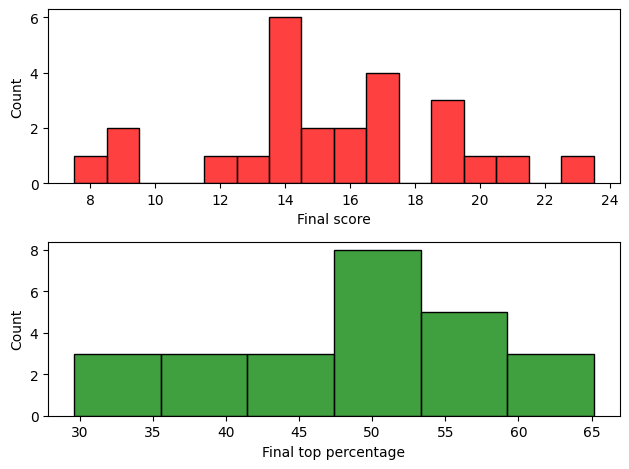

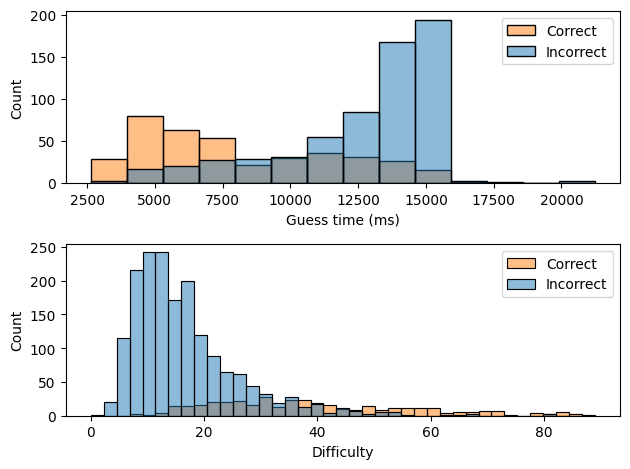

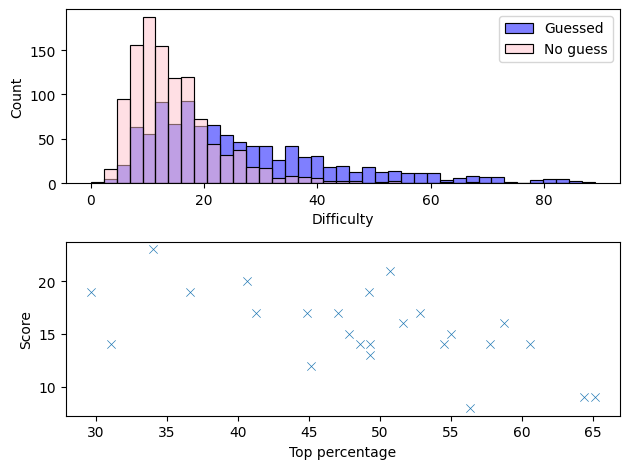

In [6]:
f, ax = plt.subplots(2, 1)
sns.histplot(last_song['score'], discrete=True, ax=ax[0], color='red')
sns.histplot(last_song['pos_percent'], ax=ax[1], color='green')
ax[0].set_xlabel('Final score')
ax[1].set_xlabel('Final top percentage')
f.tight_layout()
plt.show()

f, ax = plt.subplots(2, 1)
sns.histplot(data=novice, x='guessTime', hue='correct', ax=ax[0])
sns.histplot(data=novice, x='difficulty', hue='correct', ax=ax[1])
ax[0].set_xlabel('Guess time (ms)')
ax[0].legend(labels=['Correct', 'Incorrect'])
ax[1].set_xlabel('Difficulty')
ax[1].legend(labels=['Correct', 'Incorrect'])
f.tight_layout()
plt.show()

f, ax = plt.subplots(2, 1)
sns.histplot(data=novice, x='difficulty', hue=novice['guessTime'].notna(), ax=ax[0], palette=['pink', 'blue'])
sns.scatterplot(last_song, x='pos_percent', y='score', marker='x', ax=ax[1])
ax[0].set_xlabel('Difficulty')
ax[0].legend(labels=['Guessed', 'No guess'])
ax[1].set_xlabel('Top percentage')
ax[1].set_ylabel('Score')
f.tight_layout()
plt.show()

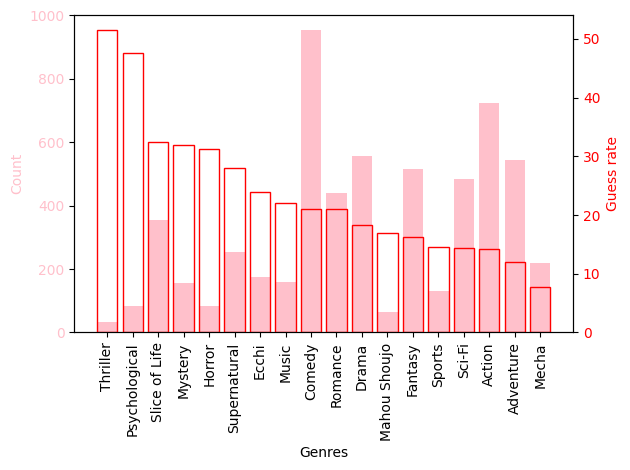

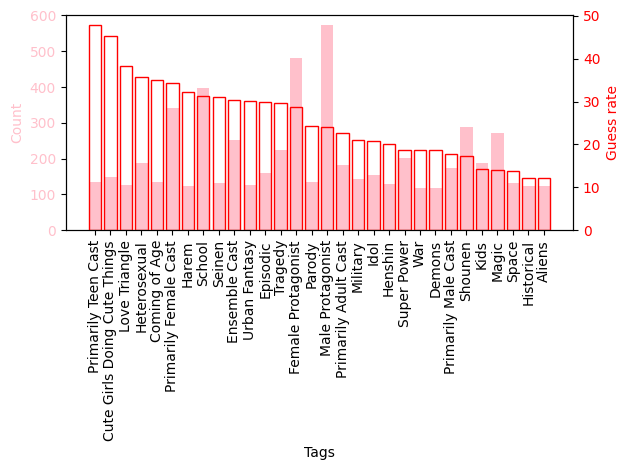

In [7]:
f, ax_p = plt.subplots()
color = 'pink'
ax_p.set_xlabel('Genres')
ax_p.set_ylabel('Count', color=color)
ax_p.bar(genres['Count'].keys().tolist(), genres['Count'], color=color)
ax_p.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax_c = ax_p.twinx()

color = 'red'
ax_c.set_ylabel('Guess rate', color=color)
ax_c.bar(genres['Count'].keys().tolist(), genres['Guess rate'], edgecolor=color, fill=False)
ax_c.tick_params(axis='y', labelcolor=color)

f.tight_layout()
plt.show()

f, ax_p = plt.subplots()
color = 'pink'
ax_p.set_xlabel('Tags')
ax_p.set_ylabel('Count', color=color)
ax_p.bar(tags['Count'].keys().tolist(), tags['Count'], color=color)
ax_p.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax_c = ax_p.twinx()

color = 'red'
ax_c.set_ylabel('Guess rate', color=color)
ax_c.bar(tags['Count'].keys().tolist(), tags['Guess rate'], edgecolor=color, fill=False)
ax_c.tick_params(axis='y', labelcolor=color)

f.tight_layout()
plt.show()